In [3]:
import requests

In [4]:
# This gives information for each station that remains stable over time
url_stations = 'https://gbfs.citibikenyc.com/gbfs/en/station_information.json'

In [5]:
# This gives the live status of all the stations (e.g., bikes available etc)
url_status = 'https://gbfs.citibikenyc.com/gbfs/en/station_status.json'

In [3]:
# We fetch for now just the time-invariant data
results = requests.get(url_stations).json() 

In [4]:
# We only need a subset of the data in the JSON returned by the Citibike API, so we keep only what we need
stations = results["data"]["stations"]

In [5]:
# We will not be using dataframes for this insertion task. (See the G2 notebook if you want to use Pandas)
# We just put the data in a dataframe to understand what is going on.
import pandas as pd
df_stations = pd.DataFrame(stations)
df_stations.head(5)

,capacity,eightd_has_key_dispenser,eightd_station_services,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id
0,57,True,[{'id': '32461582-cd1e-4ecf-a5ea-563593fa7009'...,True,40.764397,-73.973715,Grand Army Plaza & Central Park S,71,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6839.10,281
1,33,True,[{'id': 'a58d9e34-2f28-40eb-b4a6-c8c01375657a'...,True,40.704633,-74.013617,Broadway & Battery Pl,71,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,4962.01,304
2,53,False,[{'id': '2e104e31-606a-44af-8b25-ceaffc338489'...,True,40.755103,-73.974987,E 47 St & Park Ave,71,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6584.12,359
3,45,False,[{'id': '6628a325-b5ea-45be-86d0-adfb59293176'...,True,40.722438,-74.005664,6 Ave & Canal St,71,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,5500.07,377
4,39,False,[{'id': '37a1ae1b-3dd6-4876-8c57-572aaac97981'...,True,40.740343,-73.989551,Broadway & E 22 St,71,"[KEY, CREDITCARD]",http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,6098.07,402


In [1]:
# Now, let's connect to our database, where we will store our data.
from sqlalchemy import create_engine

conn_string = 'mysql://{user}:{password}@{host}/citibike?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'root',
    password = 'xxxxxxxxxxxx')

engine = create_engine(conn_string)
con = engine.connect()

OperationalError: (_mysql_exceptions.OperationalError) (1045, "Access denied for user 'root'@'54.174.159.22' (using password: YES)") (Background on this error at: http://sqlalche.me/e/e3q8)

In [9]:
# This will be the name of our database.
db_name = 'citibike'

In [10]:
# Just bookkeeping. Drop the database if it is already there
create_db_query = "DROP DATABASE IF EXISTS {db}".format(db=db_name)
engine.execute(create_db_query)

In [11]:
# Run a query to create a database that will hold the data
create_db_query = "CREATE DATABASE IF NOT EXISTS {db} DEFAULT CHARACTER SET 'utf8mb4'".format(db=db_name)

# Create a database
engine.execute(create_db_query)

In [12]:
# Create the two tables. One for storing the time-invariant station data
# and another table to store the time-varying station status data
table_name = 'stations'
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table} 
                                (station_id int, 
                                name varchar(250), 
                                capacity int,
                                lat float,
                                lon float,
                                region_id int,
                                short_name varchar(250),
                                rental_url varchar(250),
                                eightd_has_key_dispenser bool,
                                PRIMARY KEY(station_id)
                                )'''.format(db=db_name, table=table_name)
engine.execute(create_table_query)

In [14]:
# We fetch for now just the time-invariant data
# Notice that we have the INSERT IGNORE so that even when we add the same entry
# again, we do not get an error that the line exists. We do get warnings
# but this is expected

table_name = 'stations'
query_template = '''INSERT IGNORE INTO {db}.{table}(station_id, 
                                        name,
                                        capacity, 
                                        lat, 
                                        lon,
                                        region_id,
                                        short_name,
                                        rental_url,
                                        eightd_has_key_dispenser) 
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)'''.format(db=db_name, table=table_name)

for entry in data:
    station_id = int(entry['station_id'])
    name = entry['name']
    capacity = entry['capacity']
    lat = entry['lat']
    lon = entry['lon']
    region_id = entry.get('region_id')
    short_name = entry['short_name']
    rental_url = entry['rental_url']
    eightd_has_key_dispenser = entry['eightd_has_key_dispenser']
                       
    print("Inserting station", station_id, "at", name)
    query_parameters = (station_id, name, capacity, lat, lon,
                        region_id, short_name, rental_url, eightd_has_key_dispenser)
    engine.execute(query_template, query_parameters)


Inserting station 281 at Grand Army Plaza & Central Park S
Inserting station 304 at Broadway & Battery Pl
Inserting station 359 at E 47 St & Park Ave
Inserting station 377 at 6 Ave & Canal St
Inserting station 402 at Broadway & E 22 St
Inserting station 426 at West St & Chambers St
Inserting station 487 at E 20 St & FDR Drive
Inserting station 491 at E 24 St & Park Ave S
Inserting station 520 at W 52 St & 5 Ave
Inserting station 3223 at E 55 St & 3 Ave
Inserting station 3255 at 8 Ave & W 31 St
Inserting station 3443 at W 52 St & 6 Ave
Inserting station 72 at W 52 St & 11 Ave
Inserting station 79 at Franklin St & W Broadway
Inserting station 82 at St James Pl & Pearl St
Inserting station 83 at Atlantic Ave & Fort Greene Pl
Inserting station 119 at Park Ave & St Edwards St
Inserting station 120 at Lexington Ave & Classon Ave
Inserting station 127 at Barrow St & Hudson St
Inserting station 128 at MacDougal St & Prince St
Inserting station 143 at Clinton St & Joralemon St
Inserting station

Inserting station 420 at Clermont Ave & Lafayette Ave
Inserting station 421 at Clermont Ave & Park Ave
Inserting station 422 at W 59 St & 10 Ave
Inserting station 423 at W 54 St & 9 Ave
Inserting station 427 at Bus Slip & State St
Inserting station 432 at E 7 St & Avenue A
Inserting station 433 at E 13 St & Avenue A
Inserting station 435 at W 21 St & 6 Ave
Inserting station 436 at Hancock St & Bedford Ave
Inserting station 437 at Macon St & Nostrand Ave
Inserting station 438 at St Marks Pl & 1 Ave
Inserting station 440 at E 45 St & 3 Ave
Inserting station 441 at E 52 St & 2 Ave
Inserting station 442 at W 27 St & 7 Ave
Inserting station 443 at Bedford Ave & S 9 St
Inserting station 445 at E 10 St & Avenue A
Inserting station 446 at W 24 St & 7 Ave
Inserting station 447 at 8 Ave & W 52 St
Inserting station 448 at W 37 St & 10 Ave
Inserting station 450 at W 49 St & 8 Ave
Inserting station 453 at W 22 St & 8 Ave
Inserting station 454 at E 51 St & 1 Ave
Inserting station 455 at 1 Ave & E 44

Inserting station 3124 at 46 Ave & 5 St
Inserting station 3125 at 45 Rd & 11 St
Inserting station 3126 at 44 Dr & Jackson Ave
Inserting station 3127 at 9 St & 44 Rd
Inserting station 3128 at 21 St & 43 Ave
Inserting station 3129 at Queens Plaza North & Crescent St
Inserting station 3130 at 21 St & Queens Plaza North
Inserting station 3131 at E 68 St & 3 Ave
Inserting station 3132 at E 59 St & Madison Ave
Inserting station 3134 at 3 Ave & E 62 St
Inserting station 3135 at E 75 St & 3 Ave
Inserting station 3136 at 5 Ave & E 63 St
Inserting station 3137 at 5 Ave & E 73 St
Inserting station 3139 at E 72 St & Park Ave
Inserting station 3140 at 1 Ave & E 78 St
Inserting station 3141 at 1 Ave & E 68 St
Inserting station 3142 at 1 Ave & E 62 St
Inserting station 3143 at 5 Ave & E 78 St
Inserting station 3144 at E 81 St & Park Ave
Inserting station 3145 at E 84 St & Park Ave
Inserting station 3146 at E 81 St & 3 Ave
Inserting station 3147 at E 85 St & 3 Ave
Inserting station 3148 at E 84 St & 1

Inserting station 3362 at Madison Ave & E 82 St
Inserting station 3363 at E 102 St & Park Ave
Inserting station 3364 at Carroll St & 5 Ave
Inserting station 3365 at 3 St & 7 Ave
Inserting station 3366 at West End Ave & W 107 St
Inserting station 3367 at 5 Ave & E 103 St
Inserting station 3368 at 5 Ave & 3 St
Inserting station 3369 at E 82 St & East End Ave
Inserting station 3370 at E 78 St & 2 Ave
Inserting station 3371 at 4 Ave & 2 St
Inserting station 3372 at E 74 St & 1 Ave
Inserting station 3373 at 3 St & 3 Ave
Inserting station 3374 at Central Park North & Adam Clayton Powell Blvd
Inserting station 3375 at 3 Ave & E 72 St
Inserting station 3376 at E 65 St & 2 Ave
Inserting station 3377 at Carroll St & Bond St
Inserting station 3378 at E 76 St & Park Ave
Inserting station 3379 at E 103 St & Lexington Ave
Inserting station 3381 at 3 St & Hoyt St
Inserting station 3382 at Carroll St & Smith St
Inserting station 3383 at Cathedral Pkwy & Broadway
Inserting station 3384 at Smith St & 3 

Inserting station 3576 at Park Pl & Vanderbilt Ave
Inserting station 3577 at 34 Ave & 21 St
Inserting station 3578 at Park Pl & Franklin Ave
Inserting station 3579 at Sterling Pl & Bedford Ave
Inserting station 3580 at St Johns Pl & Washington Ave
Inserting station 3581 at Underhill Ave & Lincoln Pl
Inserting station 3582 at Lincoln Pl & Classon Ave
Inserting station 3583 at Eastern Pkwy & Washington Ave
Inserting station 3584 at Eastern Pkwy & Franklin Ave
Inserting station 3585 at Union St & Bedford Ave
Inserting station 3586 at 34 Ave & 13 St
Inserting station 3587 at Carroll St & Washington Ave
Inserting station 3588 at Vernon Blvd & 10 St
Inserting station 3589 at Broadway & 12 St
Inserting station 3590 at Carroll St & Franklin Ave
Inserting station 3591 at 21 St & 31 Dr
Inserting station 3592 at Crescent St & Broadway
Inserting station 3593 at 31 St & Broadway
Inserting station 3595 at 35 St & Broadway
Inserting station 3596 at Sullivan Pl & Bedford Ave
Inserting station 3597 at 

In [17]:
check = pd.read_sql("SELECT * FROM citibike.stations", con=engine)
check

,station_id,name,capacity,lat,lon,region_id,short_name,rental_url,eightd_has_key_dispenser
0,72,W 52 St & 11 Ave,39,40.7673,-73.9939,71,6926.01,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
1,79,Franklin St & W Broadway,33,40.7191,-74.0067,71,5430.08,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
2,82,St James Pl & Pearl St,27,40.7112,-74.0002,71,5167.06,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
3,83,Atlantic Ave & Fort Greene Pl,62,40.6838,-73.9763,71,4354.07,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
4,119,Park Ave & St Edwards St,19,40.6961,-73.9780,71,4700.06,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
5,120,Lexington Ave & Classon Ave,19,40.6868,-73.9593,71,4452.03,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
6,127,Barrow St & Hudson St,31,40.7317,-74.0067,71,5805.05,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
7,128,MacDougal St & Prince St,30,40.7271,-74.0030,71,5687.04,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
8,143,Clinton St & Joralemon St,24,40.6924,-73.9934,71,4605.04,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0
9,144,Nassau St & Navy St,19,40.6984,-73.9807,71,4812.02,http://app.citibikenyc.com/S6Lr/IBV092JufD?sta...,0


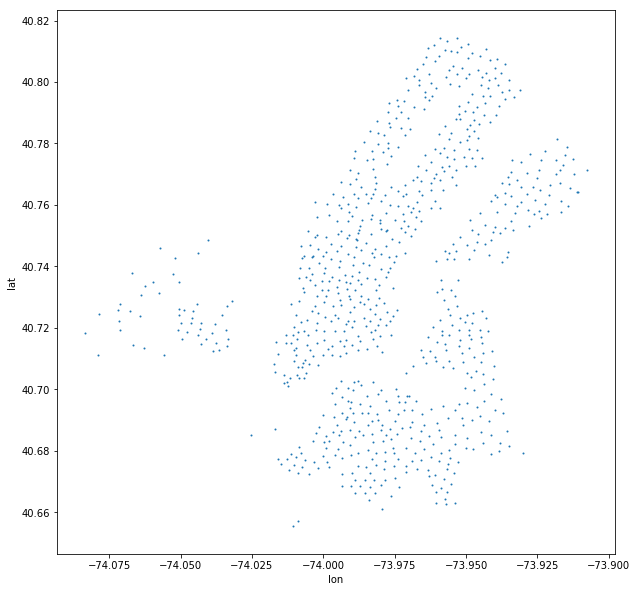

In [18]:
%matplotlib inline
check.plot(kind='scatter', x='lon', y='lat', s=1, figsize=(10,10))

In [19]:
# Create the time-varying table
table_name = 'Status'
create_table_query = '''CREATE TABLE IF NOT EXISTS {db}.{table} 
                                (station_id int, 
                                last_reported datetime,
                                num_bikes_available int,
                                num_ebikes_available int,
                                num_bikes_disabled int,
                                num_docks_available int,
                                num_docks_disabled int,
                                is_installed bool,
                                is_renting bool,
                                is_returning bool,
                                eightd_has_available_keys bool,
                                PRIMARY KEY(station_id, last_reported)
                                )'''.format(db=db_name, table=table_name)
engine.execute(create_table_query)

In [7]:
results = requests.get(url_status).json() 
status = results["data"]["stations"]
status[0]

{'station_id': '359',
 'num_bikes_available': 17,
 'num_ebikes_available': 0,
 'num_bikes_disabled': 3,
 'num_docks_available': 32,
 'num_docks_disabled': 1,
 'is_installed': 1,
 'is_renting': 1,
 'is_returning': 1,
 'last_reported': 1538077165,
 'eightd_has_available_keys': False,
 'eightd_active_station_services': [{'id': '2e104e31-606a-44af-8b25-ceaffc338489'}]}

In [21]:
# Now we fetch the data about the time varying elements of the citibike stations
from datetime import datetime

table_name = 'status'
query_template = '''INSERT IGNORE INTO {db}.{table}(station_id, 
                                            num_bikes_available,
                                            num_ebikes_available,
                                            num_bikes_disabled,
                                            num_docks_available,
                                            num_docks_disabled,
                                            is_installed,
                                            is_renting,
                                            is_returning,
                                            last_reported,
                                            eightd_has_available_keys) 
                    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)'''.format(db=db_name, table=table_name)

for entry in status:
    station_id = int(entry['station_id'])
    num_bikes_available = entry['num_bikes_available']
    num_bikes_disabled = entry['num_bikes_disabled']
    num_ebikes_available = entry['num_ebikes_available']
    num_docks_available = entry['num_docks_available']
    num_docks_disabled = entry['num_docks_disabled']
    is_installed = entry['is_installed']
    is_renting = entry['is_renting']
    is_returning = entry['is_returning']
    last_reported = datetime.fromtimestamp(entry['last_reported']) 
    eightd_has_available_keys = entry['eightd_has_available_keys']
                       
    print("Inserting station", station_id)
    query_parameters = (station_id, num_bikes_available, num_ebikes_available, num_bikes_disabled,
                        num_docks_available, num_docks_disabled, is_installed, is_renting,
                        is_returning, last_reported, eightd_has_available_keys)
    engine.execute(query_template, query_parameters)



Inserting station 281
Inserting station 304
Inserting station 359
Inserting station 377
Inserting station 402
Inserting station 426
Inserting station 487
Inserting station 491
Inserting station 520
Inserting station 3223
Inserting station 3255
Inserting station 3443
Inserting station 72
Inserting station 79
Inserting station 82
Inserting station 83
Inserting station 119
Inserting station 120
Inserting station 127
Inserting station 128
Inserting station 143
Inserting station 144
Inserting station 146
Inserting station 150
Inserting station 151
Inserting station 157
Inserting station 164
Inserting station 167
Inserting station 168
Inserting station 173
Inserting station 174
Inserting station 195
Inserting station 212
Inserting station 216
Inserting station 217
Inserting station 223
Inserting station 228
Inserting station 229
Inserting station 232
Inserting station 236
Inserting station 237
Inserting station 238
Inserting station 239
Inserting station 241
Inserting station 242
Inserting s

Inserting station 3136
Inserting station 3137
Inserting station 3139
Inserting station 3140
Inserting station 3141
Inserting station 3142
Inserting station 3143
Inserting station 3144
Inserting station 3145
Inserting station 3146
Inserting station 3147
Inserting station 3148
Inserting station 3150
Inserting station 3151
Inserting station 3152
Inserting station 3153
Inserting station 3155
Inserting station 3156
Inserting station 3157
Inserting station 3158
Inserting station 3159
Inserting station 3160
Inserting station 3161
Inserting station 3162
Inserting station 3163
Inserting station 3164
Inserting station 3165
Inserting station 3166
Inserting station 3167
Inserting station 3168
Inserting station 3169
Inserting station 3170
Inserting station 3171
Inserting station 3172
Inserting station 3173
Inserting station 3175
Inserting station 3177
Inserting station 3178
Inserting station 3179
Inserting station 3180
Inserting station 3182
Inserting station 3183
Inserting station 3184
Inserting s

Inserting station 3590
Inserting station 3591
Inserting station 3592
Inserting station 3593
Inserting station 3595
Inserting station 3596
Inserting station 3597
Inserting station 3598
Inserting station 3599
Inserting station 3601
Inserting station 3602
Inserting station 3603
Inserting station 3604
Inserting station 3605
Inserting station 3606
Inserting station 3607
Inserting station 3608
Inserting station 3609
Inserting station 3610
Inserting station 3611
Inserting station 3612
Inserting station 3613
Inserting station 3614
Inserting station 3615
Inserting station 3616
Inserting station 3617
Inserting station 3618
Inserting station 3619
Inserting station 3620
Inserting station 3621
Inserting station 3622
Inserting station 3623
Inserting station 3625
Inserting station 3628
Inserting station 3629
Inserting station 3630
Inserting station 3631
Inserting station 3632
Inserting station 3635
Inserting station 3637
Inserting station 3638
Inserting station 3639
Inserting station 3640
Inserting s

In [ ]:
check = pd.read_sql("SELECT * FROM citibike.status", con=engine)
check
